# Transformer
Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 尽管transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## Transformer整体模型
Transformer作为编码器－解码器架构的一个实例，其整体架构图如下所示：
![transformer架构](./transformer.svg)

:label:`fig_transformer`

## 编码器

### 基于位置的前馈网络
基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [19]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [11]:
torch.tensor([[1]]).unsqueeze(0)

torch.Size([1, 1, 1])

### 残差连接和层规范化
现在让我们关注transformer中的“*加法和规范化*（add&norm）”组件，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

现在我们可以[**使用残差连接和层规范化**]来实现`AddNorm`类。暂退法也被作为正则化方法使用。

In [20]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

有了组成transformer编码器的基础组件，现在可以先[**实现编码器中的一个层**]。下面的`EncoderBlock`类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

In [21]:
class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            query_size, key_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

在实现下面的[**transformer编码器**]的代码中，我们堆叠了`num_layers`个`EncoderBlock`类的实例。由于我们使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [66]:
class TransformerEncoder(nn.Module):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                num_heads, num_layers, dropout, use_bias=False):
        super(TransformerEncoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(query_size, key_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
    
    def forward(self, X, valid_lens):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

## 解码器

[**transformer解码器也是由多个相同的层组成**]。在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

In [45]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, query_size, key_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_inputs, 
                 ffn_num_hiddens, num_heads, dropout, i):
        super(DecoderBlock, self).__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            query_size, key_size, value_size, num_hiddens, num_heads, dropout)
        
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的[**transformer解码器**]。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。

In [46]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout):
        super(TransformerDecoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练
依照transformer架构来实例化编码器－解码器模型。在这里，指定transformer的编码器和解码器都是2层，都使用4头注意力。为了进行序列到序列的学习，我们在“英语－法语”机器翻译数据集上训练transformer模型。

In [47]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

In [48]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [49]:
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

In [50]:
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

In [67]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_X, dec_X, X_valid_len):
        enc_outputs = self.encoder(enc_X, X_valid_len)
        dec_state = self.decoder.init_state(enc_outputs, X_valid_len)
        return self.decoder(dec_X, dec_state)

In [68]:
net = EncoderDecoder(encoder, decoder)

In [69]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), Y_valid_len.sum())
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f} ')

loss 0.027 


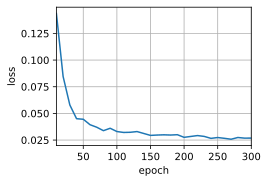

In [70]:
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测

In [73]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=True):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [74]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
